# Вступление

___

Для тренировки модели необходимо для начала подготовить данные. Для работы с данными хорошо подходят библиотеки: numpy, pandas и matplotlib.

Для начала импортируем эти библиотеки.

В дальнейшем в этот блок кода будем добавлять и другие библиотеки по мере необходимости

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.model_selection import train_test_split
from google.colab import drive
from sklearn.metrics import ndcg_score

# Загрузка данных

Поскольку данные представлены в табличном формате удобнее всего с ними работать в виде датафрейма pandas. Файл с данными достаточно большой, поэтому предварительное его рекомендуется загрузить на гугл диск. Google Colab хорошо работает с гугл диском, поэтому смонтируем его в ноутбук

In [2]:
drive.mount('/content/drive')
path_to_dir = '/content/drive/MyDrive/Colab Notebooks/vk_ml_ingener_intern'
name_dataset = 'intern_task.csv'
df = pd.read_csv('/'.join([path_to_dir, name_dataset]))

Mounted at /content/drive


# Изучение данных

Дальше необходимо понять что из себя представляют данные


In [3]:
print(df.head(10))
print(df.shape)

   rank  query_id  feature_0  feature_1  feature_2  feature_3  feature_4  \
0     0        10        1.0        0.0        1.0        3.0        3.0   
1     1        10        3.0        0.0        3.0        0.0        3.0   
2     0        10        3.0        0.0        2.0        0.0        3.0   
3     1        10        3.0        0.0        3.0        0.0        3.0   
4     2        10        3.0        0.0        3.0        1.0        3.0   
5     1        10        3.0        0.0        3.0        1.0        3.0   
6     1        10        3.0        0.0        3.0        0.0        3.0   
7     0        10        0.0        0.0        0.0        0.0        0.0   
8     0        10        2.0        0.0        1.0        0.0        2.0   
9     0        10        3.0        0.0        0.0        0.0        3.0   

   feature_5  feature_6  feature_7  ...  feature_134  feature_135  \
0   0.333333        0.0   0.333333  ...          0.0     0.000000   
1   1.000000        0.0  

Видим, что наш датасет состоит из 235258 строк и 146 столбцов. Столбец rank, столбец query_id и 144 столбца feature.

Проверим датафрейм на пропуск значений

In [4]:
print(df.isnull().sum().sum())

0


Пустых значений в датафрейме нет.

Проверим наличие дубликатов

In [5]:
print(df[df.duplicated()])

Empty DataFrame
Columns: [rank, query_id, feature_0, feature_1, feature_2, feature_3, feature_4, feature_5, feature_6, feature_7, feature_8, feature_9, feature_10, feature_11, feature_12, feature_13, feature_14, feature_15, feature_16, feature_17, feature_18, feature_19, feature_20, feature_21, feature_22, feature_23, feature_24, feature_25, feature_26, feature_27, feature_28, feature_29, feature_30, feature_31, feature_32, feature_33, feature_34, feature_35, feature_36, feature_37, feature_38, feature_39, feature_40, feature_41, feature_42, feature_43, feature_44, feature_45, feature_46, feature_47, feature_48, feature_49, feature_50, feature_51, feature_52, feature_53, feature_54, feature_55, feature_56, feature_57, feature_58, feature_59, feature_60, feature_61, feature_62, feature_63, feature_64, feature_65, feature_66, feature_67, feature_68, feature_69, feature_70, feature_71, feature_72, feature_73, feature_74, feature_75, feature_76, feature_77, feature_78, feature_79, feature_

Дубликатов нет.

Проверим типы данных

In [6]:
print(df.dtypes.value_counts())

float64    140
int64        6
Name: count, dtype: int64


Все данные в датафрейме числовые. 140 столбцов с плавающей точкой и 6 столбцов целочисленные.

Посмотрим на целочисленные данные

In [7]:
int_data = df.loc[:, df.dtypes == 'int64']
print(int_data.head(10))
print(int_data.tail(10))

   rank  query_id  feature_64  feature_65  feature_72  feature_100
0     0        10           0           0           1            0
1     1        10           0           0           1            0
2     0        10           0           0           1            0
3     1        10           0           0           1            0
4     2        10           0           0           1            0
5     1        10           0           0           1            0
6     1        10           0           0           1            0
7     0        10           0           0           1            0
8     0        10           0           0           1            0
9     0        10           0           0           1            0
        rank  query_id  feature_64  feature_65  feature_72  feature_100
235248     1     29995           0           0           1            0
235249     0     29995           0           0           1            0
235250     2     29995           0           0 

Ранк принимает вполне конкретные дискретные значения. Значения данных фич не меняются. Одинаковый id повторяется по много раз.

Поэтому посмотрим на количество уникальных значений по этим столбцам

In [8]:
for column in int_data.columns:
    print(int_data[column].value_counts())

rank
0    121521
1     75815
2     31910
3      4209
4      1803
Name: count, dtype: int64
query_id
22540    908
13930    773
22450    522
19945    444
9940     430
        ... 
22780      2
14350      2
9265       1
20560      1
28285      1
Name: count, Length: 2000, dtype: int64
feature_64
0    235258
Name: count, dtype: int64
feature_65
0    235258
Name: count, dtype: int64
feature_72
1    235258
Name: count, dtype: int64
feature_100
0    235258
Name: count, dtype: int64


Получили, что всего бывает 5 рангов ( от 0 до 4 ), при этом чем ниже ранг, тем чаще он встречается.

Получили 2000 различных id, причем некоторые встречаются чаще других.

Значения данных фич не изменяются, а значит предсказание ранга от них не зависит и их можно убрать.

Уберем из датафрейма данные, которые не вносят вклад в ранг



In [9]:
try:
    df.drop(int_data.columns[2:], axis=1, inplace=True)
except KeyError:
    print('Ошибка удаления данных, возможно вы удалили их ранее')

Посмотрим среди остальных данных нет ли одинаковых значений

In [10]:
for column in df.columns:
    if column == 'rank' or column == 'query_id':
        continue
    if len(df[column].value_counts()) < 10:
        print(df[column].value_counts())

feature_95
1.0    164660
0.0     70598
Name: count, dtype: int64
feature_96
0.0    220724
1.0     14534
Name: count, dtype: int64
feature_97
0.0    145109
1.0     90149
Name: count, dtype: int64
feature_98
0.0    191748
1.0     43510
Name: count, dtype: int64
feature_99
1.0    172455
0.0     62803
Name: count, dtype: int64


Обнаружили 5 фич с бинарными значениями, среди остальных данных повторяющихся нет



Подсчитаем минимальное, максимальное, среднее и среднеквадратичное отклонение для каждой фичи и отобразим их ввиде графика, чтобы понять какие значения принимает каждая из фич

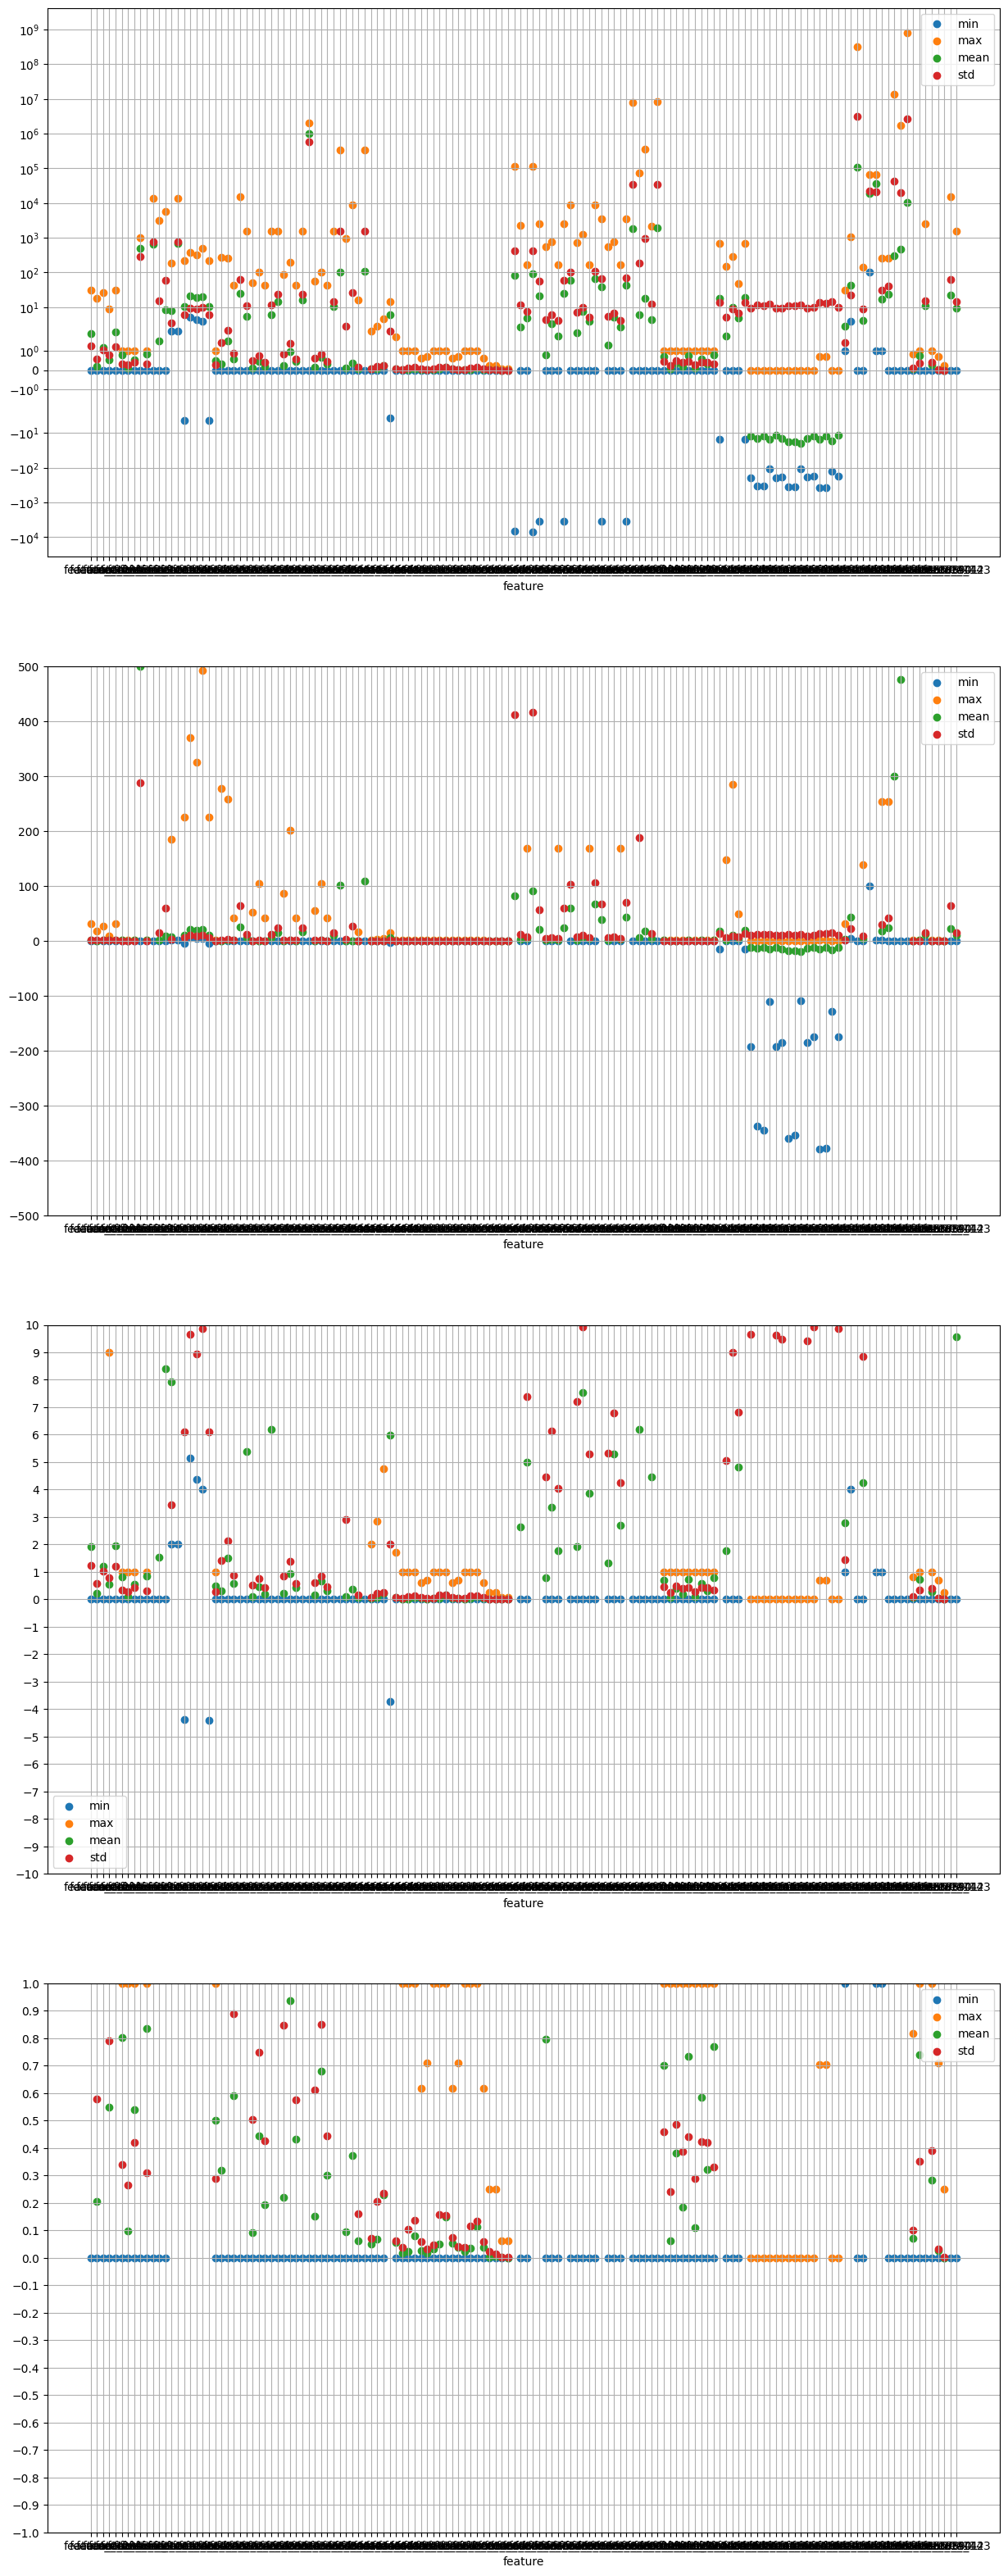

In [11]:
def show_plot(df, name_of_plot='dataframe'):
    min_seq = df.min()
    max_seq = df.max()
    mean_seq = df.mean()
    std_seq = df.std()
    plt.figure(figsize=(15, 40))
    plt.subplot(4, 1, 4)
    plt.scatter(min_seq.index, min_seq, label='min')
    plt.scatter(max_seq.index, max_seq, label='max')
    plt.scatter(mean_seq.index, mean_seq, label='mean')
    plt.scatter(std_seq.index, std_seq, label='std')
    plt.xlabel('feature')
    plt.ylim(-1, 1)
    plt.yticks(np.arange(-1, 1.1, 0.1))
    plt.grid()
    plt.legend()
    plt.subplot(4, 1, 1)
    plt.scatter(min_seq.index, min_seq, label='min')
    plt.scatter(max_seq.index, max_seq, label='max')
    plt.scatter(mean_seq.index, mean_seq, label='mean')
    plt.scatter(std_seq.index, std_seq, label='std')
    plt.xlabel('feature')
    plt.yscale('symlog')
    plt.grid()
    plt.legend()
    plt.subplot(4, 1, 3)
    plt.scatter(min_seq.index, min_seq, label='min')
    plt.scatter(max_seq.index, max_seq, label='max')
    plt.scatter(mean_seq.index, mean_seq, label='mean')
    plt.scatter(std_seq.index, std_seq, label='std')
    plt.xlabel('feature')
    plt.ylim(-10, 10)
    plt.yticks(np.arange(-10, 11, 1))
    plt.grid()
    plt.legend()
    plt.subplot(4, 1, 2)
    plt.scatter(min_seq.index, min_seq, label='min')
    plt.scatter(max_seq.index, max_seq, label='max')
    plt.scatter(mean_seq.index, mean_seq, label='mean')
    plt.scatter(std_seq.index, std_seq, label='std')
    plt.xlabel('feature')
    plt.ylim(-500, 500)
    plt.yticks(np.arange(-500, 600, 100))
    plt.grid()
    plt.legend()
    plt.show()

show_plot(df=df[df.columns[2:]])

Проанализировав данные графики можно сказать что масштаб данных очень сильно отличается. Некоторые фичи принимают значения от 0 до 1, а некоторые достигают 10^9.

Разброс данных тоже сильно отличается

Попробуем сделать различные нормализации

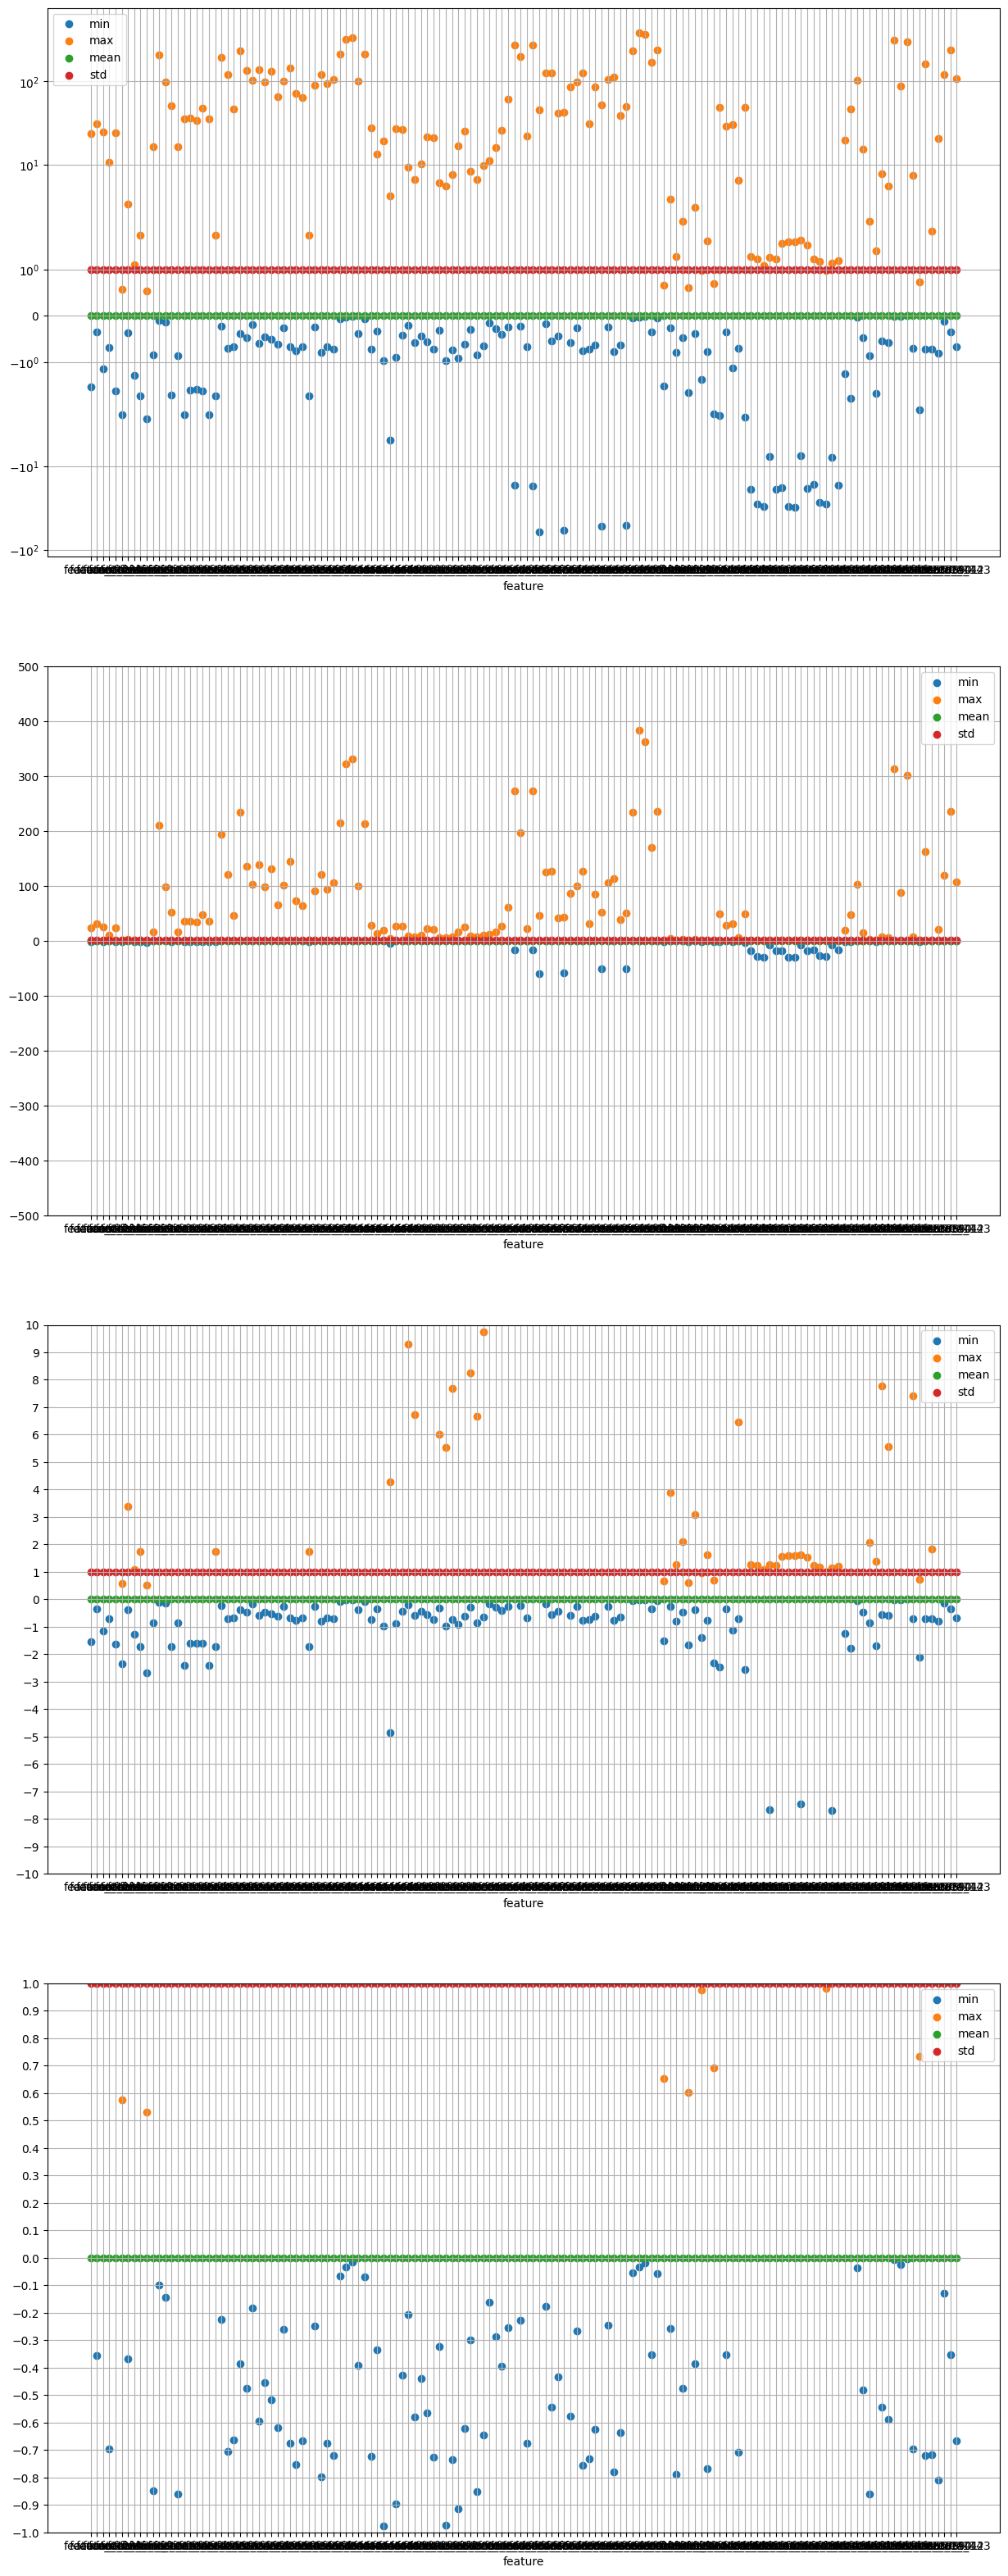

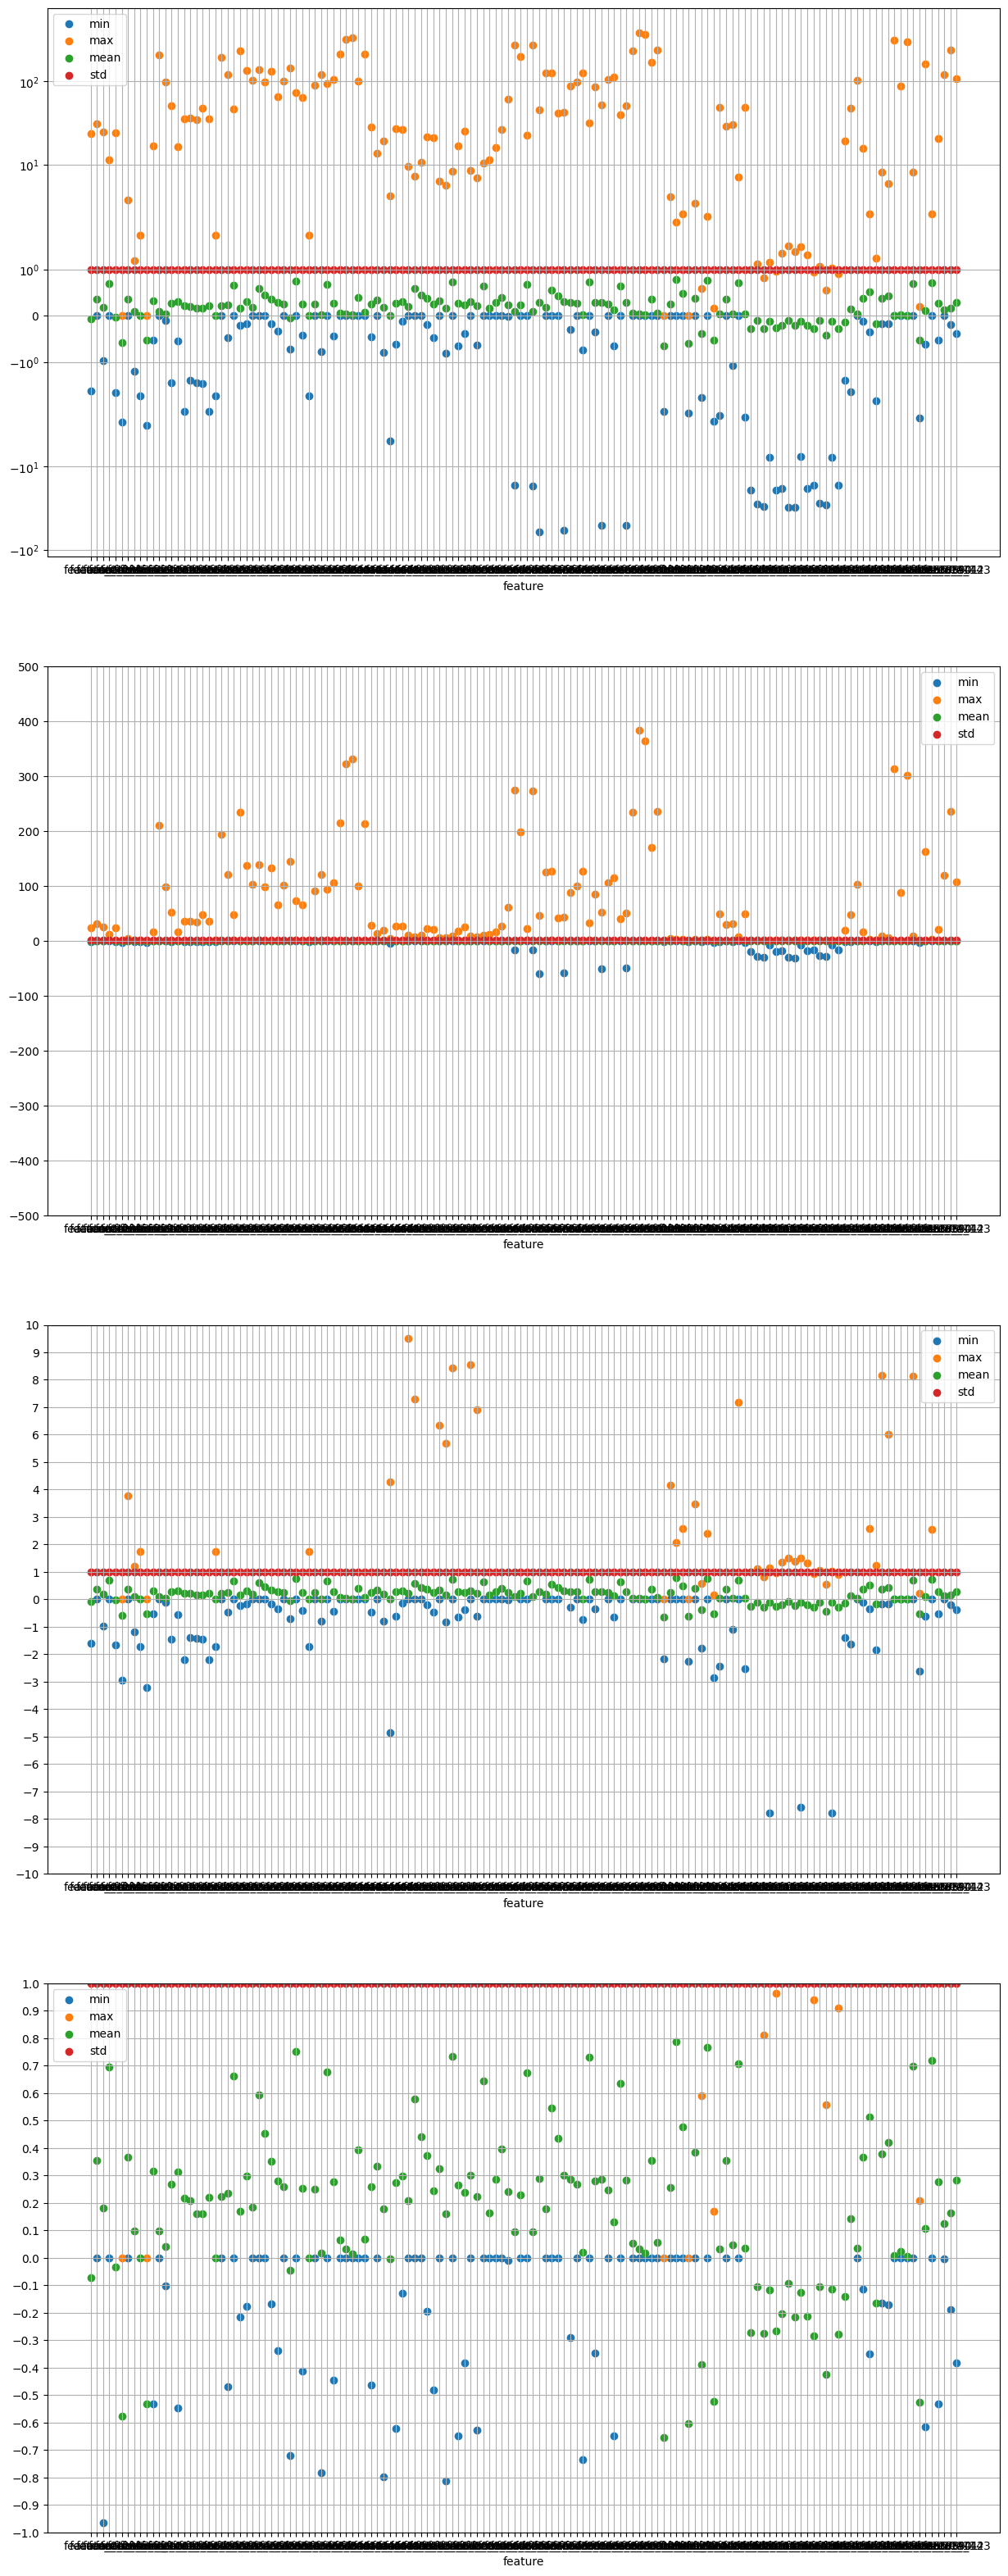

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: All values for SymLogScale are below linthresh, making it effectively linear. You likely should lower the value of linthresh. 
  fig.canvas.print_figure(bytes_io, **kw)


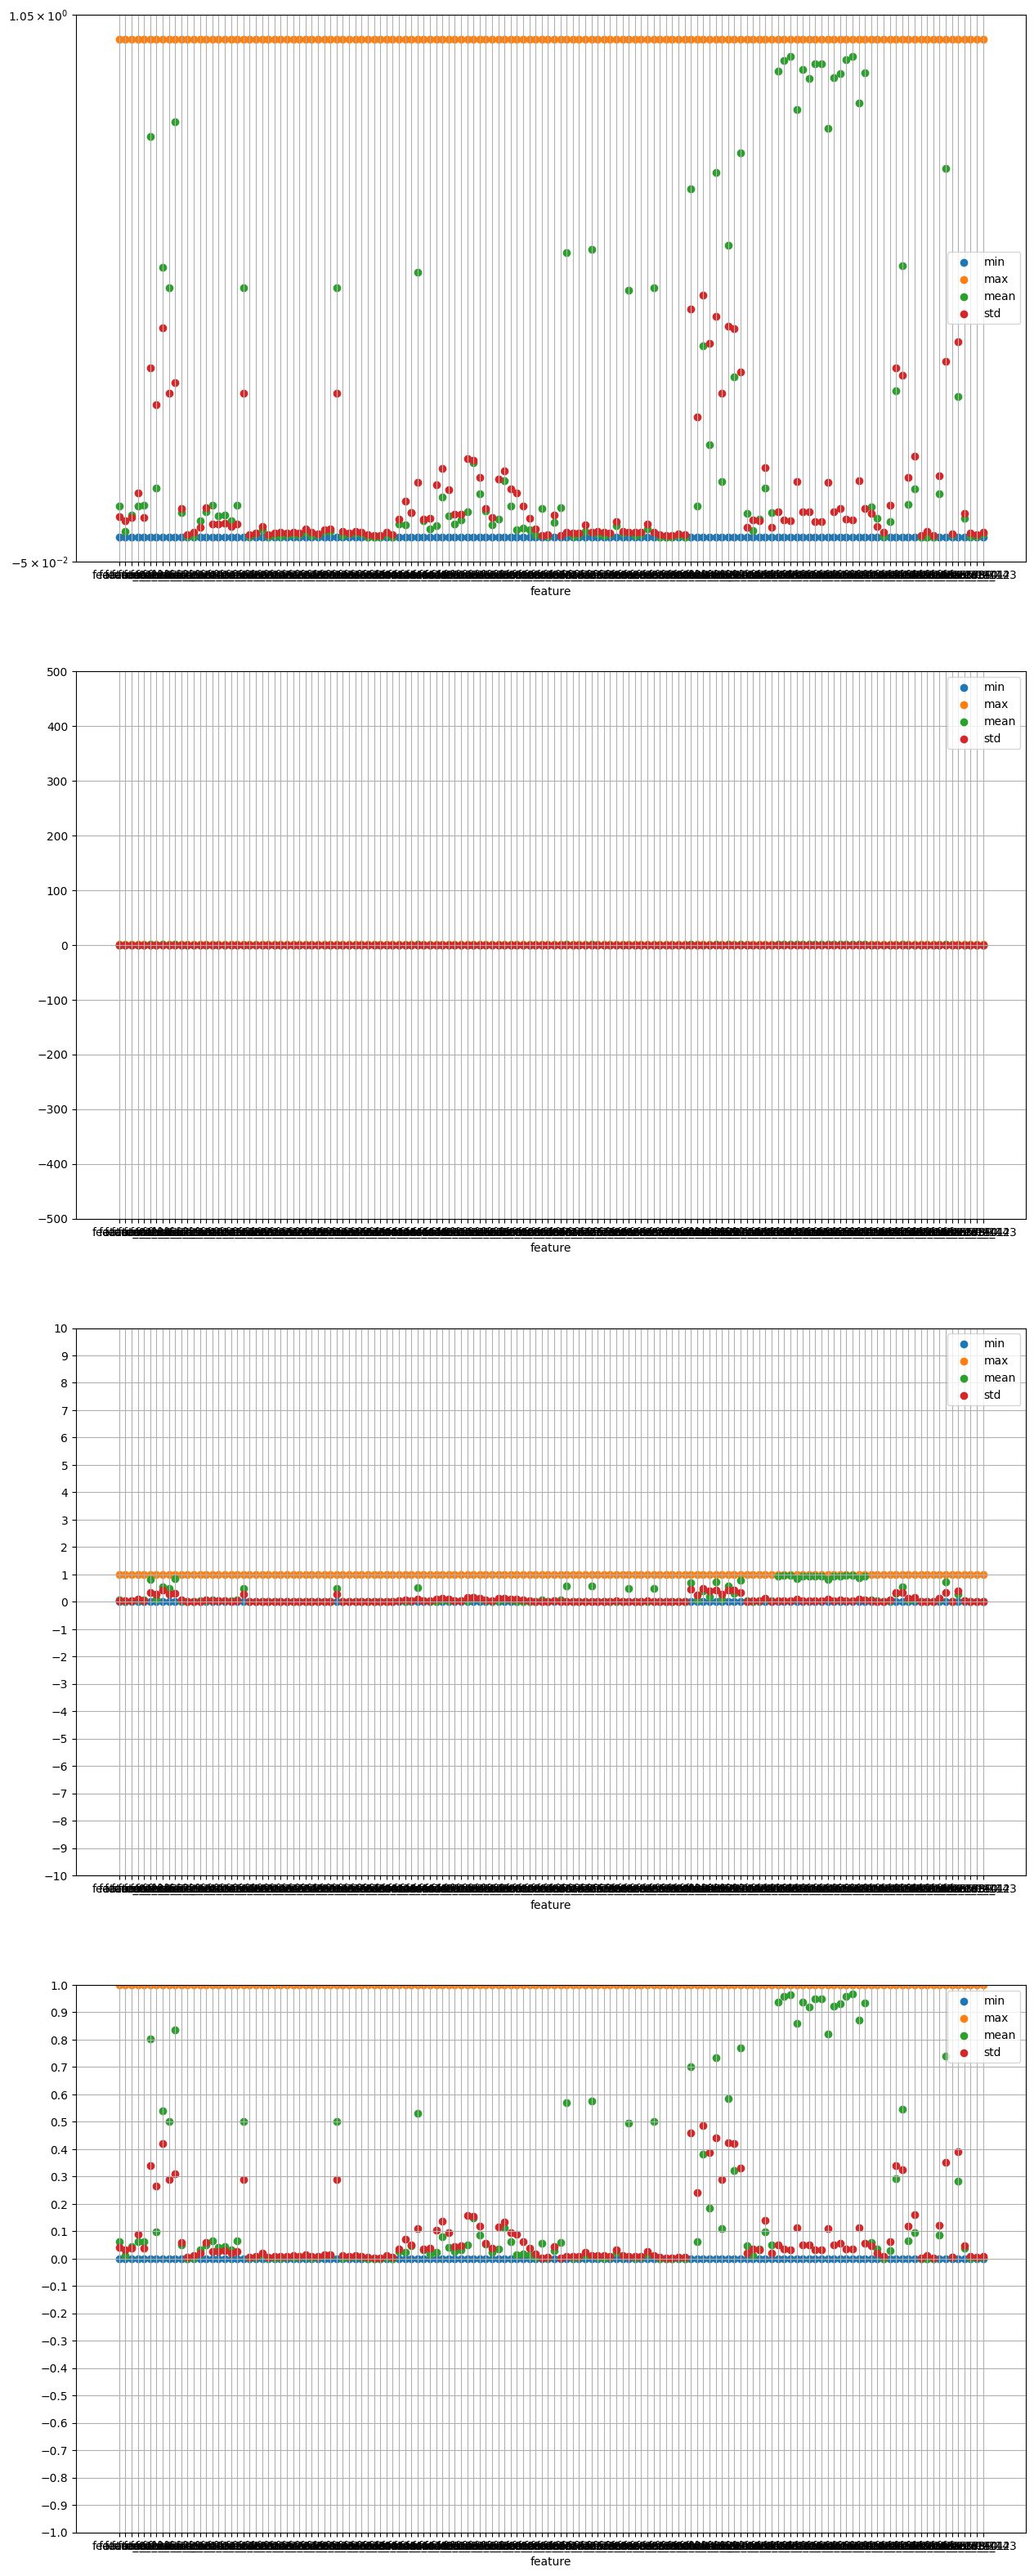

In [12]:
df_z = (df[df.columns[2:]] - df[df.columns[2:]].mean()) / df[df.columns[2:]].std()
df_z_med = (df[df.columns[2:]] - df[df.columns[2:]].median()) / df[df.columns[2:]].std()
df_norm = (df[df.columns[2:]] - df[df.columns[2:]].min()) / (df[df.columns[2:]].max() - df[df.columns[2:]].min())
show_plot(df_z, name_of_plot='z_normalization')
show_plot(df_z_med, name_of_plot='z_normalization_with_median')
show_plot(df_norm, name_of_plot='MinMax_normalization')

Сделаем предположение, что z нормализация с использованием медианы наиболее корректно описывает влияние фич на ранг. Из-за сильных выбросов в данных минмакс нормализация очень сильно зануляет влияние большинства признаков. Медиана лучше среднего описывает срединное значение в данных с выбросами.

Необходимо построить модель, которая не сильно чувствительна к выбросам данных.

Если не удасться добиться приемлимых результатов, то возможно стоит заменить выбросы в данных средним значением или вообще удалить их, но это следует делать с осторожностью, потому что мы не знаем природу фич. Возможно заменив их мы еще дальше отдалимся от предсказания генеральной совокупности.

Разобьем данные на обучающую и тестовую выборку с учетом query_id. А также создадим список, в который запишем количество записей в каждом запрос

In [13]:
df_z_med = pd.concat([df[['rank', 'query_id']], df_z_med], axis=1)
train_queries, test_queries = train_test_split(df_z_med['query_id'].unique(), test_size=0.2, random_state=42)
x_train = df_z_med[df_z_med['query_id'].isin(train_queries)].drop(['rank', 'query_id'], axis=1)
y_train = df_z_med[df_z_med['query_id'].isin(train_queries)]['rank']
qid_train = df_z_med[df_z_med['query_id'].isin(train_queries)]
qid_train_list = qid_train.groupby(by='query_id').size().to_list()
x_test = df_z_med[df_z_med['query_id'].isin(test_queries)].drop(['rank', 'query_id'], axis=1)
y_test = df_z_med[df_z_med['query_id'].isin(test_queries)]['rank']
qid_test = df_z_med[df_z_med['query_id'].isin(test_queries)]
qid_test_list = qid_test.groupby(by='query_id').size().to_list()

Создадим модель ранжирования на основе XGBRanker. Передадим в нее необходимые параметры и обучим ее

In [16]:
model = xgb.XGBRanker(
    tree_method='hist',
    eval_metric='ndcg',
    booster='gbtree',
    objective='rank:pairwise',
    random_state=42,
    learning_rate=0.1,
    colsample_bytree=0.9,
    eta=0.05,
    max_depth=6,
    n_estimators=110,
    subsample=0.75,
    early_stopping_rounds=10
    )

model.fit(x_train, y_train, group=qid_train_list, eval_group=[qid_test_list],
    eval_set=[(x_test, y_test)], verbose=True)

[0]	validation_0-ndcg:0.46404
[1]	validation_0-ndcg:0.48412
[2]	validation_0-ndcg:0.49779
[3]	validation_0-ndcg:0.50615
[4]	validation_0-ndcg:0.51273
[5]	validation_0-ndcg:0.51491
[6]	validation_0-ndcg:0.51848
[7]	validation_0-ndcg:0.52067
[8]	validation_0-ndcg:0.52174
[9]	validation_0-ndcg:0.52575
[10]	validation_0-ndcg:0.52362
[11]	validation_0-ndcg:0.52712
[12]	validation_0-ndcg:0.52701
[13]	validation_0-ndcg:0.52818
[14]	validation_0-ndcg:0.52938
[15]	validation_0-ndcg:0.52970
[16]	validation_0-ndcg:0.53196
[17]	validation_0-ndcg:0.53306
[18]	validation_0-ndcg:0.53590
[19]	validation_0-ndcg:0.53424
[20]	validation_0-ndcg:0.53485
[21]	validation_0-ndcg:0.53751
[22]	validation_0-ndcg:0.53713
[23]	validation_0-ndcg:0.53753
[24]	validation_0-ndcg:0.53870
[25]	validation_0-ndcg:0.53841
[26]	validation_0-ndcg:0.54034
[27]	validation_0-ndcg:0.54111
[28]	validation_0-ndcg:0.54239
[29]	validation_0-ndcg:0.54197
[30]	validation_0-ndcg:0.54174
[31]	validation_0-ndcg:0.54165
[32]	validation_0-

XGBRanker(base_score=None, booster='gbtree', callbacks=None,
          colsample_bylevel=None, colsample_bynode=None, colsample_bytree=0.9,
          device=None, early_stopping_rounds=10, enable_categorical=False,
          eta=0.05, eval_metric='ndcg', feature_types=None, gamma=None,
          grow_policy=None, importance_type=None, interaction_constraints=None,
          learning_rate=0.1, max_bin=None, max_cat_threshold=None,
          max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
          max_leaves=None, min_child_weight=None, missing=nan,
          monotone_constraints=None, multi_strategy=None, n_estimators=110,
          n_jobs=None, num_parallel_tree=None, ...)

Сделаем предсказание и подсчитаем метрику ndcg_5

In [17]:
y_predict = model.predict(x_test)
def ndcg_grouped(y_true, y_pred, groups, k=5):
    start = 0
    ndcg_scores = []
    for group in groups:
        if group == 1:
            start += 1
            continue
        end = start + group
        ndcg = ndcg_score([y_true[start:end]], [y_pred[start:end]], k=k)
        ndcg_scores.append(ndcg)
        start = end
    return np.mean(ndcg_scores)

# Расчёт NDCG@5
ndcg_value = ndcg_grouped(y_test.to_numpy(), y_predict, qid_test_list, k=5)
print(f"NDCG@5 score: {ndcg_value}")


NDCG@5 score: 0.5400208865713853
